In [1]:
import itertools
import os
import sys
import time

import cv2
import hdbscan
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
# import open3d as o3d
import seaborn as sns
import warnings

from collections import defaultdict
from mpl_toolkits import mplot3d
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
from PIL import Image
from scipy.cluster.hierarchy import fcluster, linkage, dendrogram
from scipy import signal
from scipy import stats
from skimage import io, filters, segmentation
from skimage.segmentation import felzenszwalb, mark_boundaries, quickshift, slic, watershed
from sklearn import metrics
from sklearn.cluster import DBSCAN, KMeans
from sklearn.decomposition import PCA
from sklearn.mixture import BayesianGaussianMixture, GaussianMixture
from sklearn.neighbors import KernelDensity
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler


warnings.simplefilter("ignore")

## Visualize Original and Gaussian Filtered Images

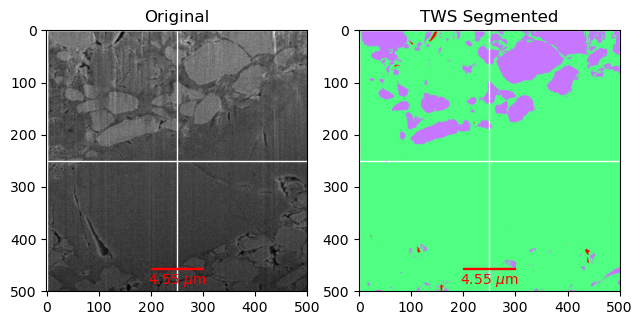

In [2]:
img = plt.imread("../unsegmented/000.tif")
img_tws = plt.imread("../segmented/000.tif")
img_tws2 = np.asarray(Image.open("../segmented/000.tif")).reshape(501, 501)
fig, ax = plt.subplots(1, 2)
ax[0].imshow(img, cmap='gray')
rect0 = patches.Rectangle((0, 0), 501, 250, edgecolor='w', fill=False)
rect1 = patches.Rectangle((0, 0), 501, 250, edgecolor='w', fill=False)
rect2 = patches.Rectangle((0, 0), 250, 501, edgecolor='w', fill=False)
rect3 = patches.Rectangle((0, 0), 250, 501, edgecolor='w', fill=False)
scalebar0 = AnchoredSizeBar(ax[0].transData,
                           100, r'4.55 $\mu$m', 'lower center', 
                           pad=0.1,
                           color='red',
                           frameon=False,
                           size_vertical=1
                           )
scalebar1 = AnchoredSizeBar(ax[1].transData,
                           100, r'4.55 $\mu$m', 'lower center', 
                           pad=0.1,
                           color='red',
                           frameon=False,
                           size_vertical=1
                           )

ax[0].add_artist(scalebar0)
ax[0].add_patch(rect0)
ax[0].add_patch(rect2)
ax[0].set_title("Original")

ax[1].imshow(img_tws, cmap='gray')
ax[1].add_patch(rect1)
ax[1].add_patch(rect3)
ax[1].add_artist(scalebar1)
ax[1].set_title("TWS Segmented")

plt.savefig("../figures/tws-segmented.png", dpi=500, pad_inches=0);
plt.tight_layout();

In [3]:
def neighborhood_mean(img, nx, ny):
    """
    Replace value with average of nx voxels in the +x direction and ny voxels in the +y direction for total a
    """
    img_out = np.zeros(img.shape)
    Nx, Ny = img.shape
    for i in range(Nx):
        for j in range(Ny):
            x = Nx - 1
            if i + nx < Nx:
                x = i + nx
            y = Ny - 1
            if j + ny < Ny:
                y = j + ny
            if np.isnan(np.nanmean(img[i:x, j:y])):
                img_out[i, j] = img[i, j]
            else:
                img_out[i, j] = np.nanmean(img[i:x, j:y])
    
    return img_out


def neighborhood_average(arr, d=(5, 5), n_min=(0, 0), n_max=(501, 501)):
    out = np.zeros(arr.shape)
    dx, dy = d
    for i in range(n_max[0]):
        for j in range(n_max[1]):
            val = arr[i, j]
            neighbors = arr[max(i - dx, 0):min(i + dx, n_max[0] - 1), max(j - dy, 0):min(j + dy, n_max[1] - 1)]
            out[i, j] = np.mean(neighbors)
    return out


def neighborhood_mode(arr, d=(5, 5), n_min=(0, 0), n_max=(501, 501)):
    out = np.zeros(arr.shape)
    dx, dy = d
    for i in range(n_max[0]):
        for j in range(n_max[1]):
            val = arr[i, j]
            neighbors = arr[max(i - dx, 0):min(i + dx, n_max[0] - 1), max(j - dy, 0):min(j + dy, n_max[1] - 1)]
            out[i, j] = np.mode(neighbors)[0][0]
    return out

# Features Matrix

# 2D Data
- Read image as data
- Apply Meijering filter to data
- Chained neighborhood average of data
    - dx = 10, dy = 10
    - dx = 10, dy = 10
    - dx = 5, dy = 5
    - dx = 5, dy = 5
- Scale data to [0, 1]
- Threshold scaled data

In [4]:
img_ = cv2.imread("../unsegmented/050.tif", cv2.IMREAD_UNCHANGED)
img_2 = filters.meijering(img_)
img_3 = neighborhood_mean(img_2, 10, 10)
img_3 = neighborhood_mean(img_3, 10, 10)
img_3 = neighborhood_mean(img_3, 5, 5)
img_3 = neighborhood_mean(img_3, 5, 5)
img = img_3 / np.max(img_3)
phases = {
    "lower_am": [0.55, 1.0],
    "lower_am_b": [0.45, 0.55],
    "lower_am_c": [0.4, 0.45],
    "se_a": [0.35, 0.4],
    "se_b": [0.325, 0.35],
    "se_c": [0.3, 0.325],
    "se_d": [0.25, 0.3],
    "se_e": [0.2, 0.25],
    "bulk_se": [0.325, 0.45],
    "top_se": [0, 0.3],
}


In [5]:
threshold = 0.075
coords = np.argwhere(np.logical_and(np.greater_equal(img, 0), np.less_equal(img, threshold)))
y = np.array([img[tuple(coords[i])] for i in range(coords.shape[0])]).reshape(-1, 1)
X_2d = np.hstack((coords, y))

# 3D Data

In [6]:
NX, NY = img_.shape
NZ = 202
threshold = 0.075
data_raw = np.zeros((NX, NY, NZ))
data = np.zeros((NX, NY, NZ))
for i in range(NZ):
    ii = str(i).zfill(3)
    img_0 = cv2.imread(f"../unsegmented/{ii}.tif", cv2.IMREAD_UNCHANGED)
    img_1 = filters.meijering(img_0)
    data[:, :, i] = img_1
    data_raw[:, :, i] = img_0

In [7]:
coords = np.argwhere(np.logical_and(np.greater_equal(data, 0), np.less_equal(data, threshold)))
y_3d = np.array([data[tuple(coords[i])] for i in range(coords.shape[0])]).reshape(-1, 1)
X_3d = np.hstack((coords, y_3d))

In [8]:
# require python version change if using anaconda
# pcd_data = o3d.data.PLYPointCloud()
# pcd = o3d.io.read_point_cloud(pcd_data.path)
# o3d.visualization.draw_geometries([pcd])

# HDBSCAN

# Optimal Threshold

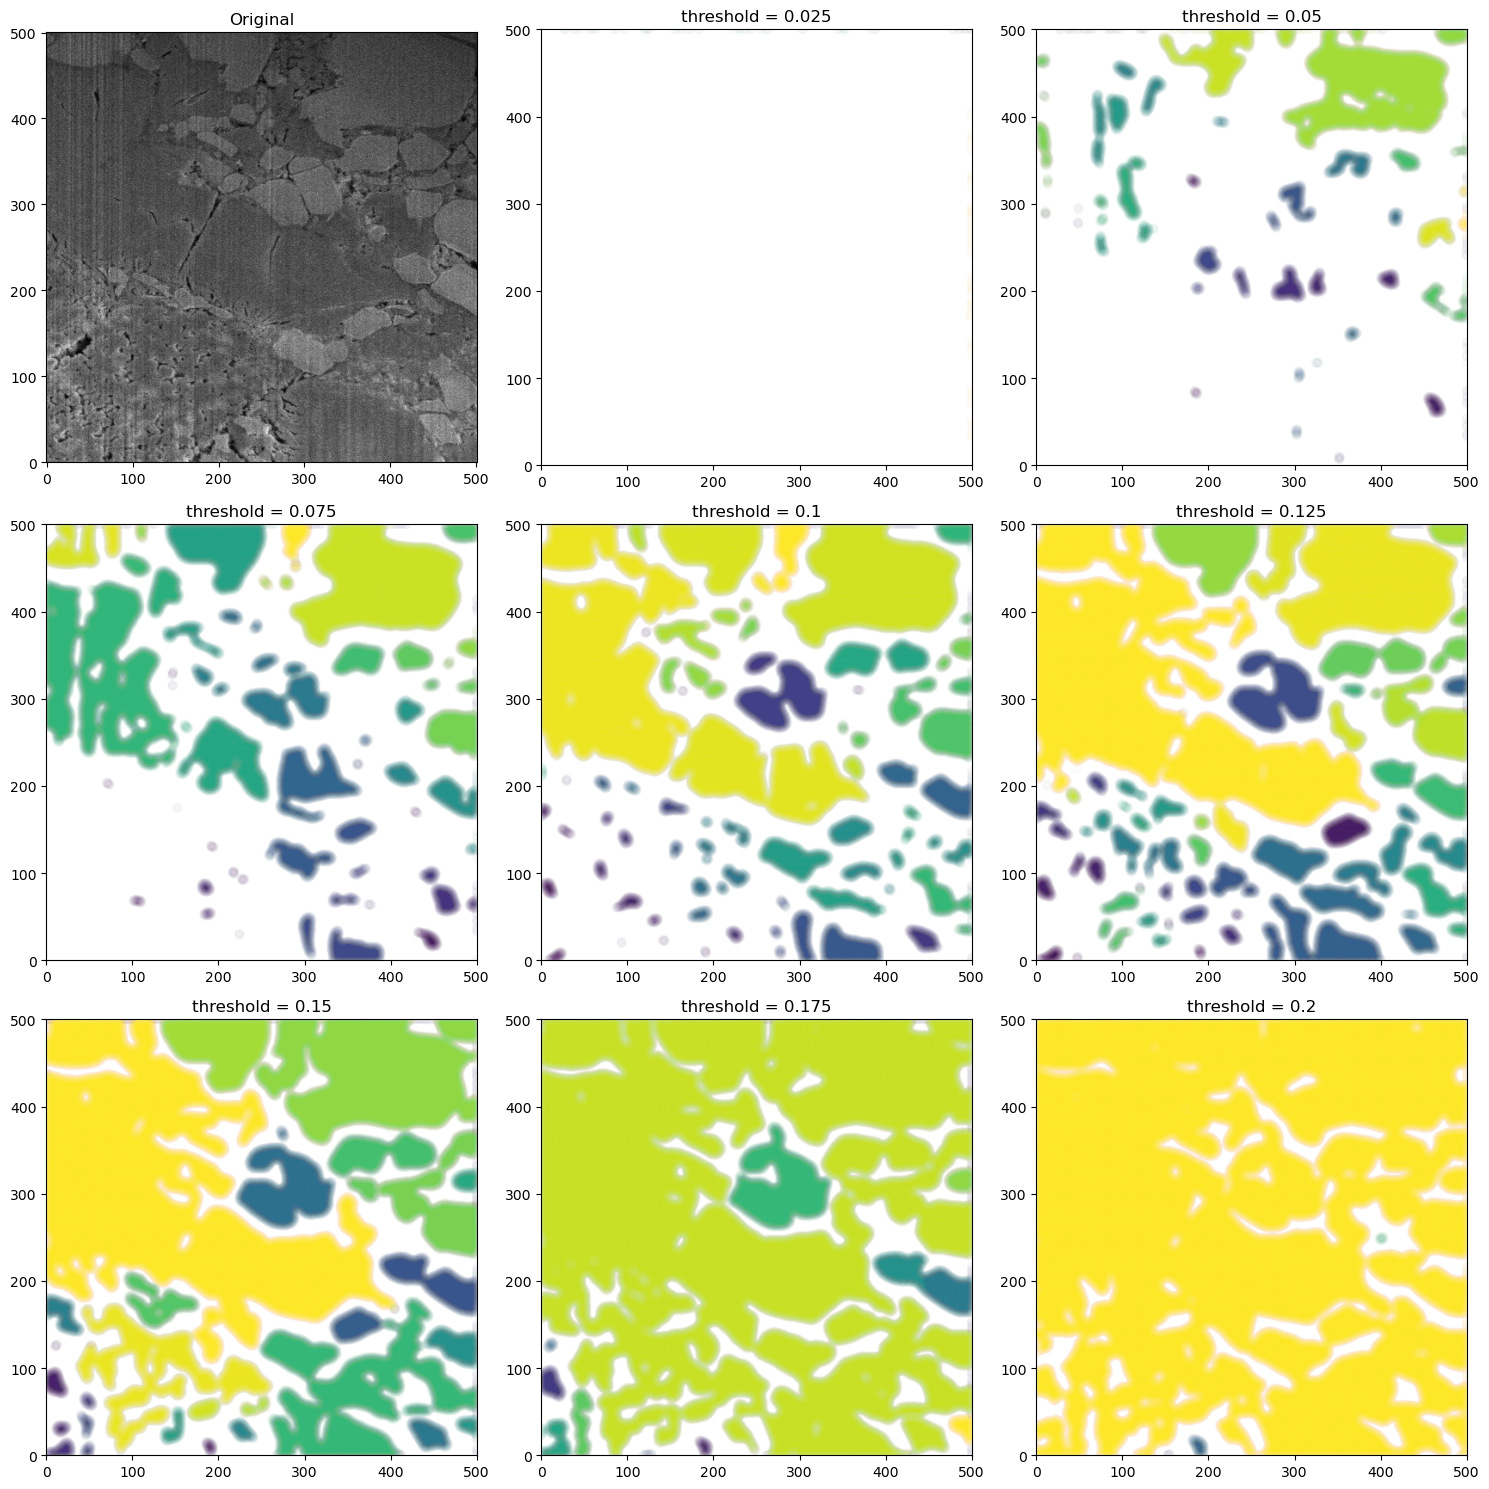

In [9]:
thresholds = [0.025, 0.05, 0.075, 0.1, 0.125, 0.15, 0.175, 0.2]
fig, ax = plt.subplots(3, 3, figsize=(15, 15))
ax[0, 0].imshow(img_, cmap='gray')
ax[0, 0].invert_yaxis();
ax[0, 0].set_title('Original');
for idx, threshold in enumerate(thresholds):
    coords = np.argwhere(np.logical_and(np.greater_equal(img, 0), np.less_equal(img, threshold)))
    y = np.array([img[tuple(coords[i])] for i in range(coords.shape[0])]).reshape(-1, 1)
    X_2d = np.hstack((coords, y))

    # hdbscan
    clusterer = hdbscan.HDBSCAN(min_cluster_size=25, cluster_selection_epsilon=5, gen_min_span_tree=True)
    y_predict = clusterer.fit_predict(X_2d).reshape(-1, 1)

    # results
    ix = int((idx + 1) / 3)
    iy = (idx + 1) % 3
    ax[ix, iy].scatter(X_2d[:, 1], X_2d[:, 0], c=y_predict, alpha=0.01)
    ax[ix, iy].set_title(f"threshold = {threshold}");
    ax[ix, iy].set_xlim([0, 500]);
    ax[ix, iy].set_ylim([0, 500]);
plt.tight_layout();

# Segmentation
* Use optimal threshold to select feature points for clusters
* Identify clusters using hdbscan
* Backfill missing values in clusters to ensure dense cluster without small holes
* Use clusters to label training data
* Update training data with void clusters information
* Deploy model using the training data in order to predict the whole image

In [10]:
threshold = 0.075
coords = np.argwhere(np.logical_and(np.greater_equal(img, 0), np.less_equal(img, threshold)))
y = np.array([img[tuple(coords[i])] for i in range(coords.shape[0])]).reshape(-1, 1)
X_2d = np.hstack((coords, y))

clusterer = hdbscan.HDBSCAN(min_cluster_size=25, cluster_selection_epsilon=2, gen_min_span_tree=True)
y_predict = clusterer.fit_predict(X_2d).reshape(-1, 1)

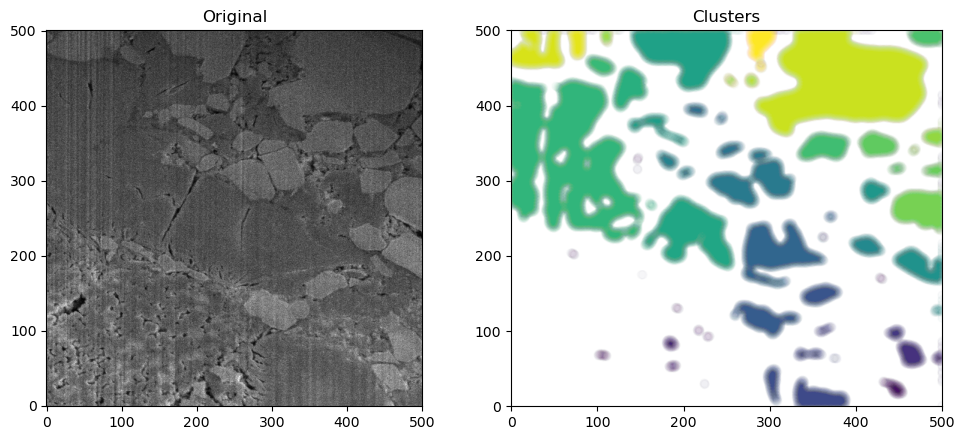

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4.5))
ax[0].imshow(img_, cmap='gray')
ax[0].invert_yaxis();
ax[1].scatter(X_2d[:, 1], X_2d[:, 0], c=y_predict, alpha=0.01)
ax[0].set_title('Original');
ax[1].set_title(f"Clusters");
ax[1].set_xlim([0, 500]);
ax[1].set_ylim([0, 500]);
plt.tight_layout();

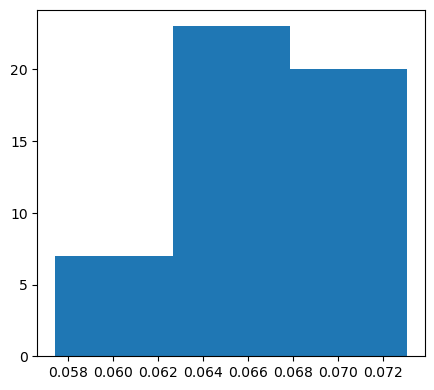

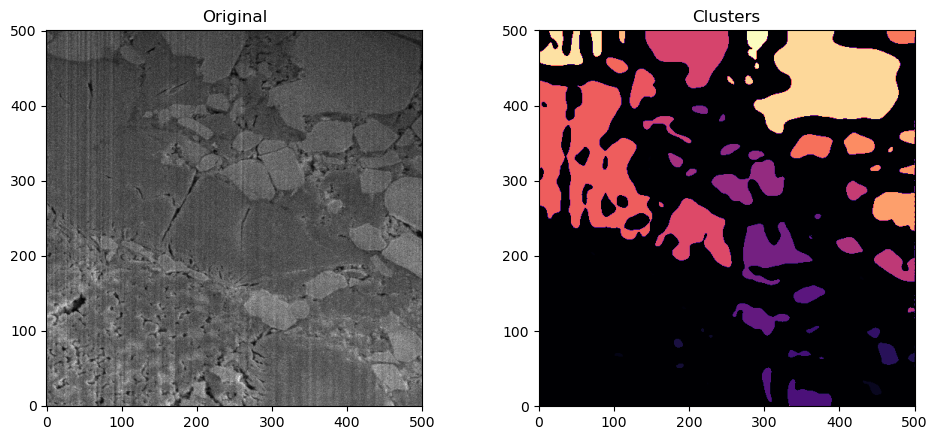

In [12]:
img_seg = -2 * np.ones(img.shape)
averages = []
fig, ax = plt.subplots(figsize=(5, 4.5))
for v in np.unique(y_predict):
    X_v = np.argwhere(y_predict == v)
    coords = list(itertools.chain.from_iterable(X_v))
    for coord in coords:
        xx, yy = X_2d[int(coord), :2]
        img_seg[int(xx), int(yy)] = v
    px_avg = np.mean(y[X_v])
    averages.append(px_avg)
ax.hist(averages, bins=3);
fig, ax = plt.subplots(1, 2, figsize=(10, 4.5))
ax[0].imshow(img_, cmap='gray')
ax[0].invert_yaxis();
ax[1].imshow(img_seg, cmap='magma')
ax[0].set_title('Original');
ax[1].set_title(f"Clusters");
ax[1].set_xlim([0, 500]);
ax[1].set_ylim([0, 500]);
plt.tight_layout();

In [13]:
new_img = -2 * np.ones(img_seg.shape)
for i in range(img_seg.shape[0]):
    for j in range(img_seg.shape[1]):
        v = img_seg[i, j]
        if v != -2:
            new_img[i, j] = v
            continue
        neighs = [
            (i, j + 1),
            (i + 1, j),
            (i, j - 1),
            (i - 1, j),
            (i + 1, j + 1),
            (i - 1, j - 1),
            (i - 1, j + 1),
            (i + 1, j - 1),
            ]
        vals = []
        for neigh in neighs:
            try:
                vals.append(img_seg[neigh])
            except IndexError:
                continue
        set_vals = set(vals)
        if -2 in set_vals:
            set_vals.remove(-2)
        if len(set_vals) == 1:
            new_img[i, j] = set_vals.pop()


-2.0 : 170192
13.0 : 1667
15.0 : 4280
19.0 : 3480
24.0 : 1608
27.0 : 5914
28.0 : 5121
31.0 : 19782
38.0 : 2429
44.0 : 17523
45.0 : 2061


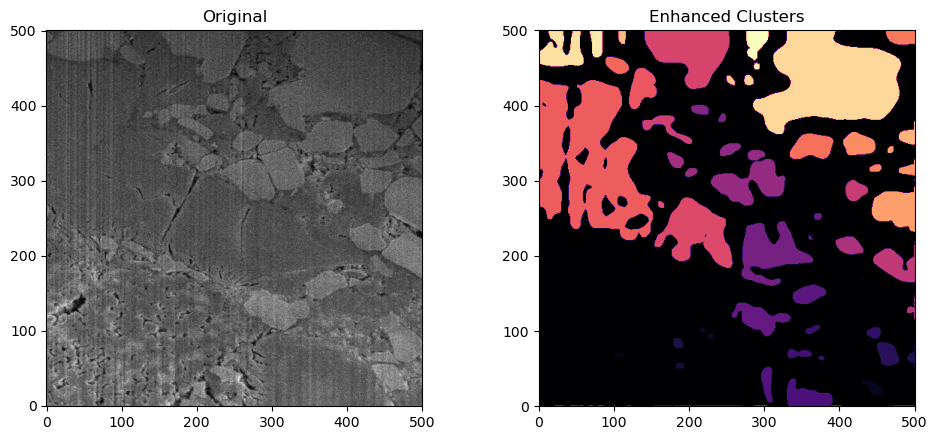

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4.5))
ax[0].imshow(img_, cmap='gray')
ax[0].invert_yaxis();
ax[1].imshow(new_img, cmap='magma')
ax[0].set_title('Original');
ax[1].set_title(f"Enhanced Clusters");
ax[1].set_xlim([0, 500]);
ax[1].set_ylim([0, 500]);
plt.tight_layout();

for v in np.unique(new_img):
    len_cluster = len(np.argwhere(new_img == v))
    if len_cluster < 1500:
        continue
    print(v, ":", len_cluster)

## Impute Missing Values in Cluster
- Use y_predict of nearest neighbors within a given distance threshold

In [15]:
d = 1

for i in range(X_2d.shape[0]):
    xx, yy = [int(v) for v in X_2d[i, :2].tolist()]
    img_seg[xx, yy] = y_predict[i]

for i in range(img.shape[0]):
    for j in range(img.shape[1]):
        val = img_seg[i, j]
        if val == -2:
            neighbors = img_seg[max(i - d, 0):min(i + d, 500), max(j - d, 0):min(j + d, 500)]
            neighbors = neighbors.reshape(-1, 1).tolist()
            
            if len(neighbors) == 0:
                continue
            mode = stats.mode(neighbors, keepdims=True)
            new_val = mode.mode
            freq = mode.count
            if new_val == -2:
                continue
            if freq < 3:
                continue
            # print(freq)
            img_seg[i, j] = new_val

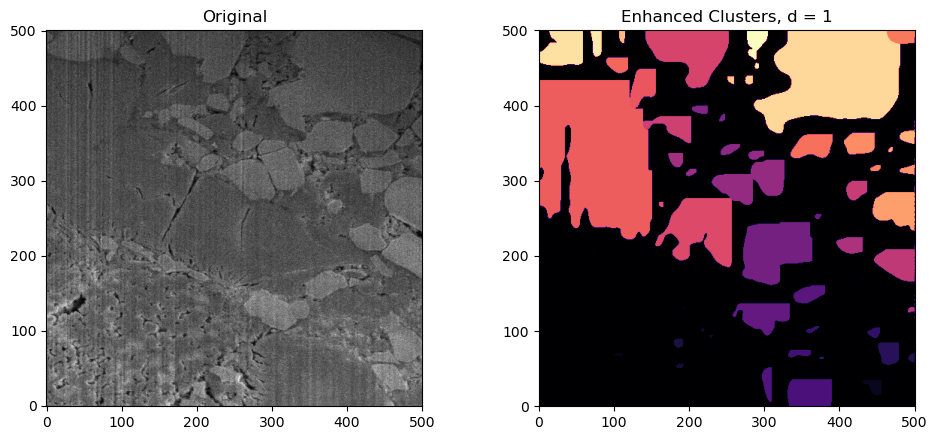

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4.5))
ax[0].imshow(img_, cmap='gray')
ax[0].invert_yaxis();
ax[1].imshow(img_seg, cmap='magma')
ax[0].set_title('Original');
ax[1].set_title(f"Enhanced Clusters, d = {d}");
ax[1].set_xlim([0, 500]);
ax[1].set_ylim([0, 500]);
plt.tight_layout();

## Kernel Density Estimation

In [17]:
# kde_1d = KernelDensity(kernel='gaussian', bandwidth=0.2)
# kde_1d.fit(X_2d)
# y_predict = kde_1d.sample(X.shape[0])[:, 2].reshape(-1, 1)

## Gaussian Mixture

In [18]:
# n = 10
# gmm = GaussianMixture(n_components=n, covariance_type="full")
# y_predict = gmm.fit_predict(X_2d)
# probs = gmm.predict_proba(X_2d)

## DBSCAN

In [19]:
# eps = 5
# min_samples = 25
# db = DBSCAN(eps=eps, min_samples=min_samples)
# db.fit(X)
# y_predict = db.fit_predict(X_2d).reshape(-1, 1)

## Bayesian Gaussian Mixture

In [20]:
# n = 10
# bgm = BayesianGaussianMixture(n_components=n, weight_concentration_prior_type='dirichlet_distribution', warm_start=True).fit(X)
# y_predict = bgm.predict(X_2d)

### FFT Band Pass Filter

In [21]:
# def H_lo(D, D0, n):
#     return 1 / (1 + (D/D0) ** (2 * n))


# def H_hi(D, D0, n):
#     return 1 / (1 + (D0/D) ** (2 * n))

# def fft_denoise(img, band_type='lo'):
#     """"""
#     if band_type not in ('lo', 'hi'):
#         raise ValueError("Unknown band type")
#     F = np.fft.fft2(img)
#     Fshift = np.fft.fftshift(F)
#     M, N = img.shape
#     H = np.zeros((M, N), dtype=np.float32)
#     n = 1
#     D0 = 0.75

#     for u in range(M):
#         for v in range(N):
#             D = np.sqrt((u - M/2) ** 2 + (v - N/2) ** 2)
#             if band_type == 'hi':
#                 H[u, v] = H_hi(D, D0, n)
#             else:
#                 H[u, v] = H_lo(D, D0, n)

#     Gshift = Fshift * H
#     G = np.fft.ifftshift(Gshift)
#     g = np.abs(np.fft.ifft2(G)) * 255
    
#     return g

# g = fft_denoise(img_, 'hi')
# D0 = 0.75
# fig, ax = plt.subplots(1, 2, figsize=(15, 15))
# ax[0].imshow(img, cmap="gray")
# rect = patches.Rectangle((150, 350), 50, 50, edgecolor='r', fill=False)
# ax[0].add_patch(rect)
# ax[0].set_title("Original")
# ax[1].imshow(g, cmap="gray")
# rect1 = patches.Rectangle((150, 350), 50, 50, edgecolor='r', fill=False)
# ax[1].add_patch(rect1)
# ax[1].set_title(f"Filtered, cut off freq = {D0}")
# plt.imsave("../figures/fft-hi-unsegmented.bmp", g, cmap='gray', format="bmp")
# plt.show()

### Identification of Clusters

In [22]:
# points = set()
# for (x, y) in np.argwhere(img_seg):
#     points.add((x, y))
# point_ids = np.zeros((len(points), 2))
# for idx, point in enumerate(points):
#     point_ids[idx, :] = point
# points_view = {(v[0], int(v[1])): k for k, v in enumerate(point_ids)}

# G = nx.Graph()
# for k, v in points_view.items():
#     G.add_node(v)
# for k in points_view.keys():
#     x, y = k
#     neighbors = [
#         (int(x + 1), y),
#         (int(x - 1), y),
#         (x, int(y + 1)),
#         (x, int(y - 1)),
#         (int(x + 1), int(y + 1)),
#     ]
#     p0 = points_view[k]
#     for neighbor in neighbors:
#         p = points_view.get(neighbor)
#         if p is None:
#             continue
#         G.add_edge(p0, p)
# pieces = nx.connected_components(G)
# pieces = [piece for piece in pieces]